In [2]:
import pandas as pd
import numpy as np

In [7]:
data = pd.read_csv('../../../nlp_poem.csv')
poem = data

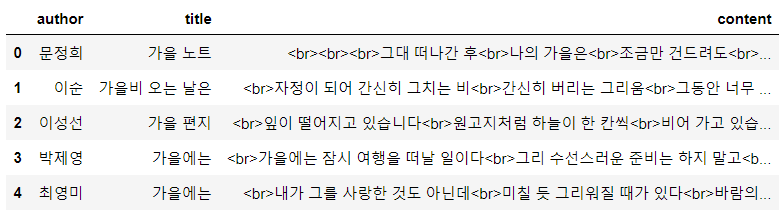

# 데이터 전처리

In [11]:
stopwords = [
    'stop', 'words'
]

In [27]:
from konlpy.tag import Okt
tagger = Okt()

# 편지 내용 가져오기
contents = poem['content']

def preprocessing(text):
    # <br>제거
    text = text.replace("<br>", " ")
    
    # 형태소 분석
    okt_pos = tagger.pos(text, norm=True, stem=True)
    
    # 명사, 동사, 형용사 사용
    words = [word for word, hts in okt_pos if hts in ['Noun','Adjective', 'Verb']]
    
    # 스탑 워드 적용
    words = [word for word in words if word not in stopwords]
    
    #리스트 문자열로 변경
    pure_string = ' '.join(words)
    
    return pure_string

content = list(contents.apply(preprocessing))

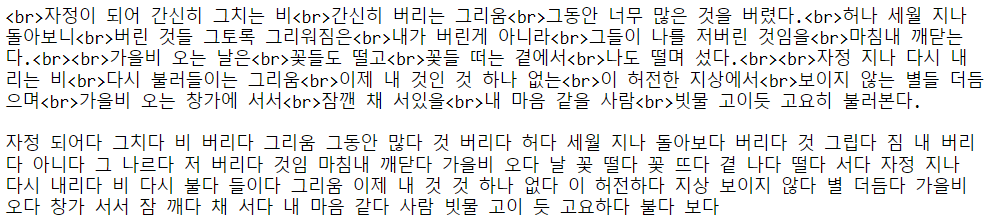

# 자주 등장하는 단어, tf-idf

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
words_vectors = vectorizer.fit_transform(content).toarray()

words_vectors = pd.DataFrame(words_vectors)

In [29]:
def index_to_word(search_num):  
    words = vectorizer.vocabulary_
    
    for word, wordnum in words.items():
        if wordnum == search_num:
            return word

In [31]:
# 단어 1,2,3 순위 랭킹 리스트로 반환 데이터 프래임 생성
index_rank_datafarme = pd.DataFrame(columns=['idf_1st', 'idf_2nd', 'idf_3rd'])

for index in range(len(words_vectors)):
    arow = words_vectors.iloc[index]
    arow = arow.sort_values(ascending=False)[0:3] #3개 5개로 바꾸면 랭킹 개수 변경 가능
    
    str_index = []
    for key, value in arow.items():
        if value != 0.0:
            str_index.append(index_to_word(key))
    
    # 시 데이터 형변한 후 단어가 2개 이하인 경우 남은 컬럼을 -1로 채워줌
    # 데이터 프래임을 만들때 컬럼수가 다르면 만들 수 없기 때문에 처리
    for i in range(3):
        if len(str_index) < 3:
            str_index.append(-1)
            
    index_rank_datafarme.loc[index] = str_index

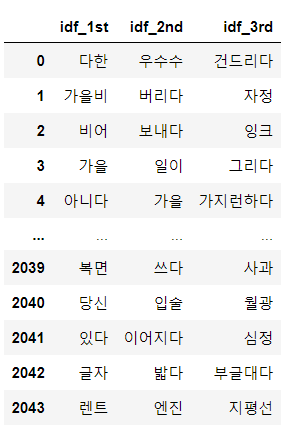

In [35]:
result_dataframe = pd.DataFrame(columns=['author', 'title', 'content', 'idf_1st', 'idf_2nd', 'idf_3rd'])

result_dataframe[['author', 'title', 'content']] = poem[['author', 'title', 'content']]
result_dataframe[['idf_1st', 'idf_2nd', 'idf_3rd']] = index_rank_datafarme[['idf_1st', 'idf_2nd', 'idf_3rd']]

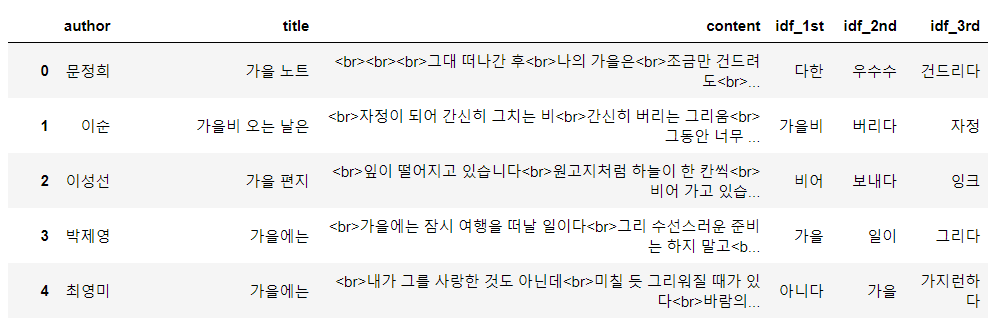

# CSV 파일 내보내기

In [37]:
result_dataframe.to_csv('poem_tf_idf_ranking.csv', index=False)